In [1]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

Using TensorFlow backend.


In [2]:
from vgg19 import VGG19

In [3]:
from PIL import Image

In [4]:
import numpy as np

# Load the pretrained VGG19 model and visualize it 

# The content image and the style image

In [5]:
def show_image(image_file, title=None):
    image = plt.imread(image_file)
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)

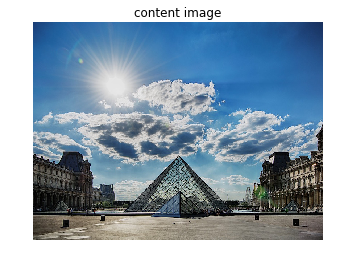

In [6]:
# the content image
show_image('image/louvre.jpg', 'content image')

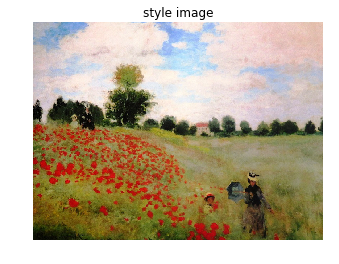

In [7]:
# the style image
show_image('image/monet_800600.jpg', 'style image')

# Define content cost function 

Definitions:
1. Select a layer in the middle of the NN, so that the feature extracted by the layer is neither too detailed (low-level) nor too abstract (high-level)

2. Denote the activation function the selected layers as $a$ with shape of $(n_H, n_W, n_C)$

3. Denote the content image as $C$ and the generated image as $G$, so that the activation of them are $a(C)$ and $a(G)$, respectively

The content loss function:

$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum \sum \sum (a^{(C)} - a^{(G)})^2\tag{1} $

In [8]:
def get_content_loss(a_C, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [n_H*n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))
    
    J_content = tf.reduce_sum(tf.square(a_C_unrolled-a_G_unrolled)) / (4*n_H*n_W*n_C)
    
    return J_content

In [9]:
tf.reset_default_graph()
with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = get_content_loss(a_C, a_G)
    print(J_content.eval())

6.7655926


In [10]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [11]:
def get_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = tf.reduce_sum(tf.square(GS - GG)) / (4*(n_C*n_H*n_W)**2)
    
    return J_style_layer

In [12]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    print(GA.eval())

[[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


In [13]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = get_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190275


In [14]:
def get_style_cost(vgg, STYLE_LAYERS):
    J_style = 0
    sess = tf.get_default_session()
    
    for layer_name, coeff in STYLE_LAYERS:
        out = vgg[layer_name]
        a_S = sess.run(out) # evaluated
        a_G = out # not evaluated
        
        J_style_layer = get_layer_style_cost(a_S, a_G)
        
        J_style += coeff * J_style_layer
    
    return J_style

In [15]:
def get_total_cost(J_content, J_style, alpha=10, beta=20):
    J = alpha*J_content + beta*J_style
    return J

In [16]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = get_total_cost(J_content, J_style)
    print("J = " + str(J))

J = 26.616481744542973


In [17]:
def reshape_image(image):
    image = np.reshape(image, ((1, ) + image.shape))
    
    return image

In [18]:
content_image = plt.imread('image/louvre_small.jpg')
content_image = reshape_image(content_image)

In [19]:
style_image = plt.imread('image/monet.jpg')
style_image = reshape_image(style_image)

In [20]:
def generate_noise_image(content_image, noise_ratio=0.4):
    noise_image = np.random.uniform(0, 255, content_image.shape).astype('float32')
    input_image = noise_image * noise_ratio + content_image*(1-noise_ratio)
    return input_image

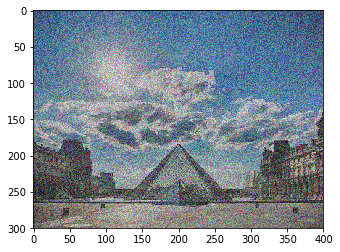

In [21]:
noise_image = generate_noise_image(content_image)
plt.imshow(np.clip(noise_image[0], 0, 255).astype('int32'))

In [22]:
IMAGE_SHAPE = (1, 300, 400, 3)

In [23]:
my_img = tf.Variable(np.zeros(IMAGE_SHAPE), dtype=tf.float32)
vgg = VGG19(image_shape=IMAGE_SHAPE, input_tensor=my_img)

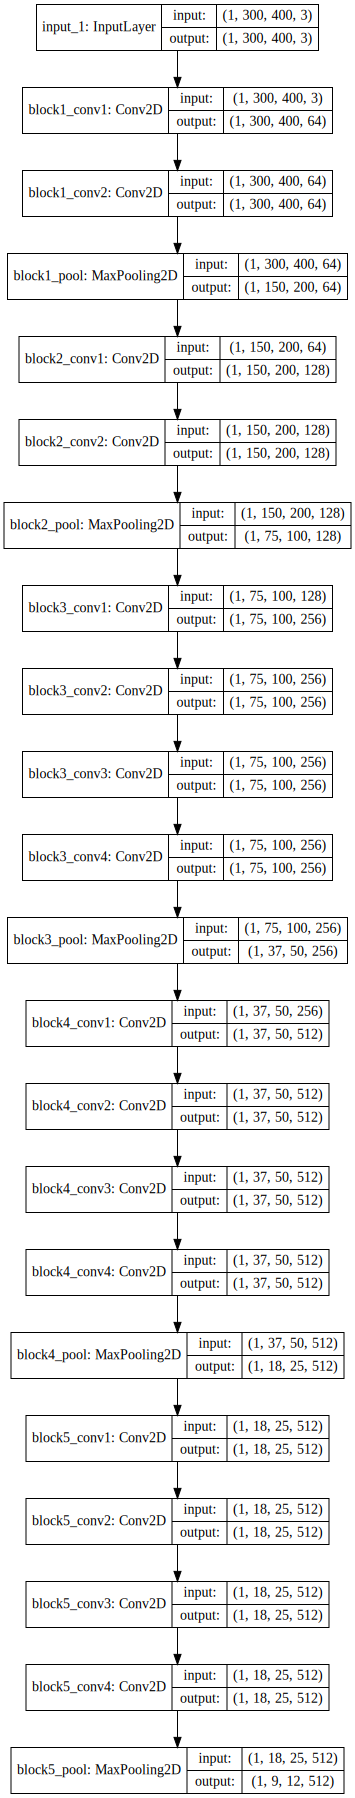

In [24]:
SVG(model_to_dot(vgg.vgg19, show_shapes=True).create(prog='dot', format='svg'))

In [25]:
STYLE_LAYERS = [
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [26]:
sess = tf.InteractiveSession()

In [27]:
vgg.load_weights()

INFO:tensorflow:Restoring parameters from /tmp/tmpuz4w39fw


In [28]:
sess.run(my_img.assign(content_image));

In [29]:
out = vgg['block4_conv2']

In [30]:
a_G = out

In [31]:
a_C = sess.run(out)

In [32]:
J_content = get_content_loss(a_C, a_G)

In [33]:
sess.run(my_img.assign(style_image));

In [34]:
J_style = get_style_cost(vgg, STYLE_LAYERS)

In [35]:
J = get_total_cost(J_content, J_style, alpha=10, beta=1)

In [36]:
optimizer = tf.train.AdamOptimizer(0.5)

In [37]:
train_step = optimizer.minimize(J, var_list=[my_img])

In [38]:
sess.run(my_img.assign(content_image));

In [39]:
sess.run(tf.global_variables_initializer())
vgg.load_weights()
for i in range(100000):
    sess.run(train_step)
    if i % 1000 == 0:
        print(i, sess.run(J))
generated_image = sess.run(my_img)

INFO:tensorflow:Restoring parameters from /tmp/tmpuz4w39fw
0 5701927000.0
1000 41099444.0
2000 23274756.0
3000 15747676.0
4000 11170284.0
5000 8427984.0
6000 6802707.5
7000 5980195.0
8000 5062174.0
9000 4613114.5
10000 4194014.0
11000 3971934.5
12000 3742884.8
13000 3799250.0
14000 3350445.5
15000 3200521.5
16000 3156719.8
17000 3021592.0
18000 2955041.0
19000 2857324.0
20000 2816779.0
21000 2732568.5
22000 2640122.0
23000 2586825.0
24000 2544416.0
25000 2533502.5
26000 2698945.0
27000 2997134.8
28000 2584443.0
29000 2356066.2
30000 2358606.2
31000 2289337.8
32000 2294347.2
33000 2241538.2
34000 2216273.5
35000 2205803.0
36000 2285260.2
37000 2159252.5
38000 2376609.2
39000 2308693.2
40000 2106519.5
41000 2411674.0
42000 2094466.0
43000 2062692.5
44000 2100661.2
45000 2040325.4
46000 2049951.6
47000 2020625.8
48000 2039171.5
49000 2003896.5
50000 1982052.2
51000 1974363.1
52000 1959683.6
53000 1953115.5
54000 1996940.2
55000 2092666.1
56000 1932396.8
57000 1923863.5
58000 1908512.2
590

In [40]:
generated_image = sess.run(my_img)

In [41]:
generated_image = generated_image[0]

In [42]:
generated_image.shape

(300, 400, 3)

In [43]:
v_max = generated_image.min(axis=-1, keepdims=True)
v_min = generated_image.max(axis=-1, keepdims=True)

In [44]:
res = (generated_image - v_min) / (v_max - v_min)

In [45]:
res.max()

1.0

In [59]:
res = res*255

In [60]:
res = res.astype('int32')

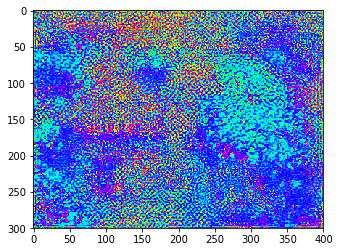

In [61]:
plt.imshow(res)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


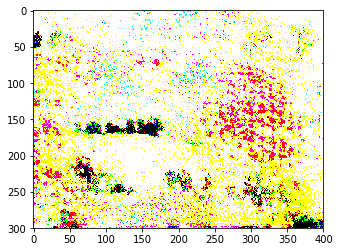

In [65]:
res2 = np.clip(generated_image, 0, 255)

plt.imshow(res2-10)

In [48]:
res2.max()

255.0

In [49]:
res2.min()

0.0

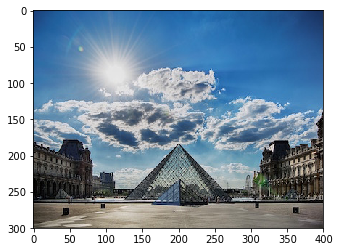

In [50]:
plt.imshow(content_image[0])

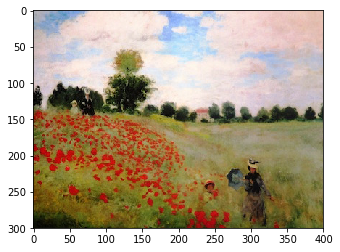

In [51]:
plt.imshow(style_image[0])